In [4]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
from matplotlib import pyplot
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

import pandas_datareader as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

import datetime as dt
from IPython.display import display, HTML

import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

/Users/rachaeltay/anaconda3/lib/python3.6/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


In [5]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping

In [7]:
# web scrap from 1/1/2016 to the most recent day for every stock
stockNames = ['AAPL', 'GOOG', 'AVGO']

def get_stock(stock, start, end):
    return pdr.get_data_yahoo(stock, start, end)['Close']

stocks = []

#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2011, 11, 6))))

RemoteDataError: Unable to read URL: https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1451577600&period2=1320595199&interval=1d&events=history&crumb=S4CsrJHFUD7

## Data Pre-Processing

In [9]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

AAPL_0    AAPL_1    GOOG_1    AVGO_1
Date                                              
2017-11-13 -0.159627 -0.232642 -0.146074 -0.307133
2017-11-14 -0.435935 -0.159627 -0.126090 -0.260855
2017-11-15 -0.382963 -0.435935 -0.067065 -0.374960
2017-11-16  0.229778 -0.382963 -0.189712 -0.115690
2017-11-17 -0.195421  0.229778  0.193386  0.148652

In [10]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 28
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training

In [11]:
#define model
model = Sequential()
model.add(LSTM(2, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.03)))
model.add(Activation('tanh'))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.03)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=500, batch_size=batch_size, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (28, 2)                   48        
_________________________________________________________________
activation_1 (Activation)    (28, 2)                   0         
_________________________________________________________________
dense_1 (Dense)              (28, 1)                   3         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
308/308 [==============================] - 0s - loss: 0.0980     
Epoch 2/500
308/308 [==============================] - 0s - loss: 0.0442     
Epoch 3/500
308/308 [==============================] - 0s - loss: 0.0383     
Epoch 4/500
308/308 [==============================] - 0s - loss: 0.0361     
Epoch 5/500
308/308 [==============================] - 0s - loss: 0.0359     
Epoch 6/500
308/308 

308/308 [==============================] - 0s - loss: 0.0350     
Epoch 96/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 97/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 98/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 99/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 100/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 101/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 102/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 103/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 104/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 105/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 106/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 107/500
308/308 [==============================] - E

308/308 [==============================] - 0s - loss: 0.0350     
Epoch 198/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 199/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 200/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 201/500
308/308 [==============================] - ETA: 0s - loss: 0.034 - 0s - loss: 0.0350     
Epoch 202/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 203/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 204/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 205/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 206/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 207/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 208/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 209/500
308/308 [=======

308/308 [==============================] - 0s - loss: 0.0350     
Epoch 402/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 403/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 404/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 405/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 406/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 407/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 408/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 409/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 410/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 411/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 412/500
308/308 [==============================] - 0s - loss: 0.0350     
Epoch 413/500
308/308 [==============================]

## Training Outcome

In [12]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(2, batch_input_shape=(new_batch_size, training_input.shape[1], training_input.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.03)))
new_model.add(Activation('sigmoid'))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.03)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

Training RMSE: 0.1713


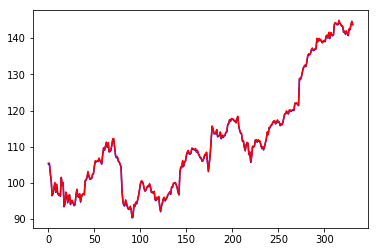

In [9]:
# training_predictions = np.concatenate((np.full((num_lags, 1), training_predictions[0]), training_predictions))
pyplot.plot(stocks[0].iloc[:training_size, :].values, color = "blue")
pyplot.plot(training_predictions, color = "red")
pyplot.show()

## Test Outcome

In [10]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 1.9027


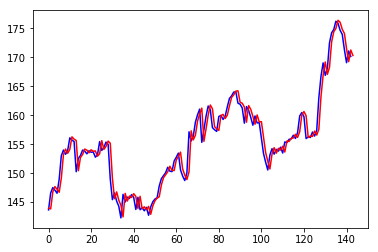

In [11]:
# test_predictions = np.concatenate((np.full((num_lags, 1), test_predictions[0]), test_predictions))

pyplot.plot(stocks[0].iloc[training_size+1:, :].values, color = "blue")
pyplot.plot(test_predictions, color = "red")
pyplot.show()

## Forecasted Price

In [35]:
test_set

AAPL_0    AAPL_1    GOOG_1    AVGO_1
Date                                              
2017-04-28 -0.079456 -0.043665 -0.014929 -0.174643
2017-05-01  0.360058 -0.079456  0.655489 -0.408558
2017-05-02  0.073728  0.360058  0.079007 -0.231695
2017-05-03 -0.123836  0.073728  0.016077 -0.002219
2017-05-04 -0.135290 -0.123836  0.170647 -0.298891
2017-05-05  0.288476 -0.135290  0.033302 -0.359113
2017-05-08  0.520399  0.288476 -0.176848 -0.070681
2017-05-09  0.080889  0.520399  0.091869 -0.350871
2017-05-10 -0.163924  0.080889 -0.121728 -0.049762
2017-05-11  0.039370 -0.163924 -0.150665 -0.082092
2017-05-12  0.248391  0.039370 -0.031007 -0.279240
2017-05-15 -0.116680  0.248391 -0.035600  0.044692
2017-05-16 -0.092340 -0.116680  0.038816 -0.069414
2017-05-17 -0.806729 -0.092340  0.063160 -0.159430
2017-05-18  0.268431 -0.806729 -0.609784 -0.866244
2017-05-19  0.015033  0.268431  0.171107  0.146752
2017-05-22  0.073730  0.015033  0.013781 -0.489699
2017-05-23 -0.086615  0.073730  0.107486  0.007290
2017-05-24 -0.125270 -0.086615  0.087047 -0.380666
2017-05-25  0.016464 -0.125270  0.068213 -0.070047
2017-05-26 -0.096635  0.016464  0.262057 -0.184152
2017-05-30 -0.050824 -0.096635 -0.028480 -0.241838
2017-05-31 -0.189693 -0.050824  0.028480 -0.352139
2017-06-01  0.000715 -0.189693 -0.325908 -0.285579
2017-06-02  0.265569  0.000715 -0.024804 -0.574009
2017-06-05 -0.277023  0.265569  0.125860  1.000000
2017-06-06  0.015033 -0.277023  0.112770 -0.411093
2017-06-07  0.072297  0.015033 -0.236105 -0.159430
2017-06-08 -0.113814  0.072297  0.027560 -0.237401
2017-06-09 -0.919830 -0.113814 -0.016078 -0.221553
...              ...       ...       ...       ...
2017-10-09  0.017894 -0.072297  0.132292 -0.132805
2017-10-10 -0.050824  0.017894 -0.116216 -0.220920
2017-10-11  0.033645 -0.050824 -0.173864 -0.291283
2017-10-12 -0.138154  0.033645  0.309601  0.015530
2017-10-13  0.082320 -0.138154 -0.105420 -0.369254
2017-10-16  0.354331  0.082320 -0.030318 -0.313471
2017-10-17  0.025053  0.354331 -0.019522 -0.345801
2017-10-18 -0.161060  0.025053 -0.068673 -0.520761
2017-10-19 -0.600573 -0.161060 -0.058337 -0.176545
2017-10-20 -0.020758 -0.600573 -0.264814 -0.245642
2017-10-23 -0.070867 -0.020758  0.013321 -0.267194
2017-10-24  0.073730 -0.070867 -0.526413 -0.262124
2017-10-25 -0.158197  0.073730 -0.024806 -0.047861
2017-10-26  0.083751 -0.158197 -0.008727 -0.381933
2017-10-27  0.748031  0.083751 -0.090492 -0.394613
2017-10-30  0.465998  0.748031  1.000000  0.315372
2017-10-31  0.272726  0.465998 -0.122417  0.264026
2017-11-01 -0.367215  0.272726 -0.083601 -0.094137
2017-11-02  0.115247 -0.367215  0.130684 -0.556893
2017-11-03  0.569076  0.115247 -0.070971 -0.250714
2017-11-06  0.191124  0.569076  0.085669  0.631696
2017-11-07  0.020758  0.191124 -0.223931 -0.017434
2017-11-08  0.145312  0.020758  0.097839 -0.657051
2017-11-09 -0.110952  0.145312  0.076941 -0.195563
2017-11-10 -0.232642 -0.110952 -0.270096 -0.692550
2017-11-13 -0.159627 -0.232642 -0.146074 -0.307133
2017-11-14 -0.435935 -0.159627 -0.126090 -0.260855
2017-11-15 -0.382963 -0.435935 -0.067065 -0.374960
2017-11-16  0.229778 -0.382963 -0.189712 -0.115690
2017-11-17 -0.195421  0.229778  0.193386  0.148652

[143 rows x 4 columns]

In [48]:
forecast = DataFrame(get_stock(stock, dt.datetime(2017, 11, 5), dt.datetime(2017, 11, 6)))

RemoteDataError: No data fetched using 'YahooDailyReader'

In [22]:
# get price of day before buy - 5-11-2017
print('Before Buy: %.3f' % test_predictions[142][0])

# get price of day on buy - 6-11-2017
print('After Buy: %.3f' % test_predictions[143][0])

Before Buy: 171.271
After Buy: 170.321


In [45]:
test_predictions.shape[0]

144